# Hackathon Banco BV- Time 11
## Como alavancar a renovação do seguro auto?
* Quais as avalancas que fazem os clientes recontratarem o seguro?
* Qual o melhor momento e maneira para oferecer a renovação do contrato?
* Qual a melhor estrátegia para garantir a melhor abordagem ao cliente?

# 1- Importação de Bibliotecas

In [1]:
! pip install imbalanced-learn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)


In [2]:
! pip install XGBoost

  Using cached xgboost-1.6.1-py3-none-manylinux2014_x86_64.whl (192.9 MB)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
sns.set(rc={'figure.figsize':(12,6)}) # isso é pras figuras ficarem maiores

# 2-Importação da base de dados

In [4]:
# conexao com o client
from google.cloud.bigquery import Client, QueryJobConfig
client = Client()

In [5]:
query = """SELECT * FROM `hacka-dados.hacka_dados.tabela_dados_hacka` """
job = client.query(query)
df = job.to_dataframe()

# 3-Verificar a integridade dos dados

In [6]:
df.shape

(50000, 306)

In [7]:
df.isnull().sum()

ID                                     0
Capacidade_de_Pagamento_7              0
tempo_desde_primeiro_contrato          0
tempo_desde_ultimo_contrato            0
QTD_SEGURO                             0
                                   ...  
NV_FC_NEGOCIACAO_COM_SUCESSO_3m    48935
NV_BP4_Informa_o_desconto_3m       48509
Duracao_segundos                   30331
fl_renovou                             0
VrFinanciamento                        1
Length: 306, dtype: int64

In [54]:
df.dropna(how='any', axis=1, inplace=True)

## 4 - Verificar a distribuição da váriavel alvo

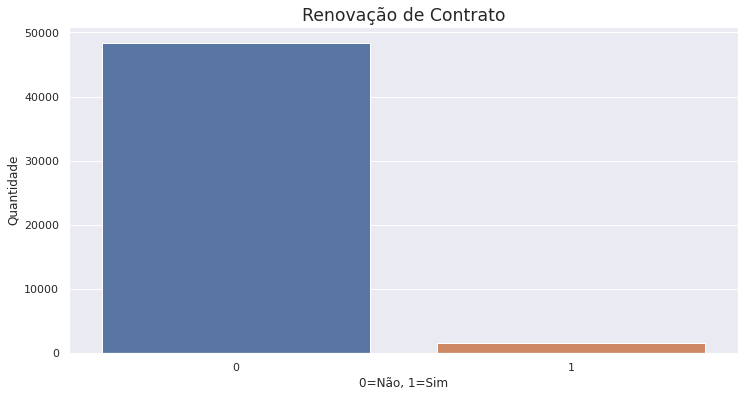

In [51]:
# Verificar como está a distribuição da variável target

sns.countplot(data=df, x=df['fl_renovou'])
plt.title("Renovação de Contrato", fontsize='x-large', style='normal')
plt.xlabel('0=Não, 1=Sim')
plt.ylabel('Quantidade')
plt.show()

## 5- Análise Explorátoria dos Dados

In [60]:
df=df.replace(to_replace ='nan', value = 'Desconhecido', regex = True)

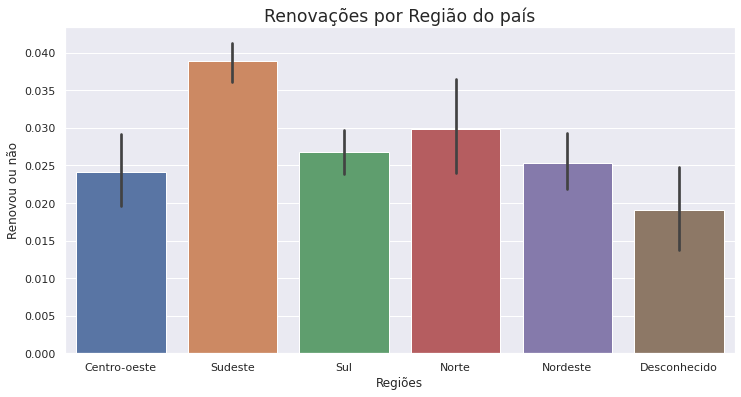

In [61]:
sns.barplot(x=df['CdUfNaturalidade'], y=df['fl_renovou'])
plt.title("Renovações por Região do país", fontsize='x-large', style='normal')
plt.xlabel('Regiões')
plt.ylabel('Renovou ou não')
plt.show()

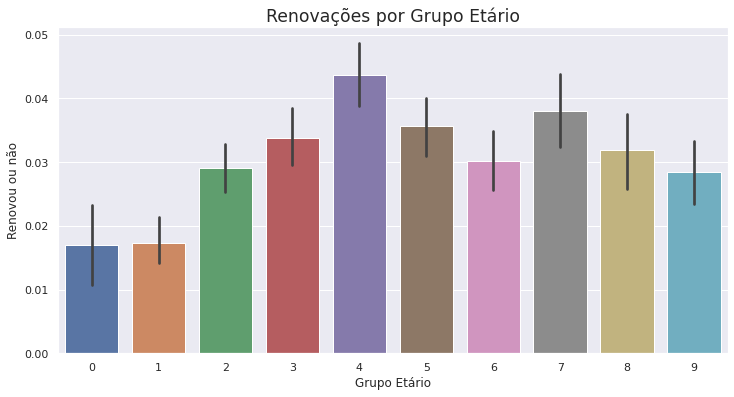

In [62]:
sns.barplot(x=df['Grupo_Etario'], y=df['fl_renovou'])
plt.title("Renovações por Grupo Etário", fontsize='x-large', style='normal')
plt.xlabel('Grupo Etário')
plt.ylabel('Renovou ou não')
plt.show()

In [11]:
df.groupby(['CdOcupacaoCBO', 'fl_renovou'], as_index=False).sum()

,CdOcupacaoCBO,fl_renovou,ID,Capacidade_de_Pagamento_7,tempo_desde_primeiro_contrato,tempo_desde_ultimo_contrato,QTD_OUTROS,QTD_CP_CONSIGNADO,QTD_CDCCG,QTD_CONTA_DIGITAL,...,VrContrato,QtParcelas,Grupo_Etario,Capacidade_de_Pagamento_1,Capacidade_de_Pagamento_2,Capacidade_de_Pagamento_3,Capacidade_de_Pagamento_4,Capacidade_de_Pagamento_5,Capacidade_de_Pagamento_6,NV_FC_CPC___Responsavel_6m
0,10101,0,17753755,3769,824837.0,82088.0,12,14,195,279,...,2.318536,24104,2130,274,-135.084812,54.111775,117.126897,-180.758164,151.124084,24
1,10101,1,542891,104,26674.0,1996.0,0,0,3,6,...,-0.667025,624,55,1,-8.877744,2.247245,6.555875,1.616023,2.859012,0
2,1103,0,12754228,3499,683502.0,86313.0,6,5,205,208,...,163.884682,22489,1961,204,-129.231649,201.818975,190.564573,-111.886738,48.953621,40
3,1103,1,984669,252,62886.0,5636.0,0,3,16,15,...,23.761238,1692,176,23,-15.116296,13.166817,14.427881,-1.739933,-4.502860,2
4,1191,0,11647639,2560,449744.0,63999.0,8,2,176,197,...,-75.705177,16411,1529,297,8.097970,-94.665424,-25.893640,57.831494,10.251549,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,9876,0,3041710,924,139222.0,26756.0,0,3,115,41,...,-14.841030,7012,939,28,2.160972,7.300623,3.481064,22.948467,65.372904,14
91,Indeterminado,0,168086995,54025,10435009.0,1615304.0,72,76,3636,1791,...,-728.095064,370058,35817,4512,-849.602522,2120.748575,1443.063277,17.827538,287.381646,927
92,Indeterminado,1,7231681,1987,418450.0,55764.0,2,4,147,73,...,30.970258,13381,1345,110,-95.965459,99.460604,64.391739,7.952454,16.997162,7
93,Outros,0,81274179,20471,3515877.0,536524.0,37,45,1393,1230,...,-307.530561,136659,12602,1834,40.985733,-248.929070,-200.626861,64.645721,51.106007,301


In [12]:
df.groupby(['Grupo_Etario', 'fl_renovou'],as_index=False).mean()


,Grupo_Etario,fl_renovou,ID,Capacidade_de_Pagamento_7,tempo_desde_primeiro_contrato,tempo_desde_ultimo_contrato,QTD_OUTROS,QTD_CP_CONSIGNADO,QTD_CDCCG,QTD_CONTA_DIGITAL,...,QTD_CP,VrContrato,QtParcelas,Capacidade_de_Pagamento_1,Capacidade_de_Pagamento_2,Capacidade_de_Pagamento_3,Capacidade_de_Pagamento_4,Capacidade_de_Pagamento_5,Capacidade_de_Pagamento_6,NV_FC_CPC___Responsavel_6m
0,0,0,23650.651729,7.176697,1117.992958,205.866837,0.021127,0.012804,0.205506,0.523688,...,0.0,-0.251890,46.749040,0.857875,0.078918,-0.094380,-0.261094,0.083375,-0.044664,0.095391
1,0,1,24388.111111,7.333333,1248.074074,196.444444,0.000000,0.000000,0.259259,0.666667,...,0.0,-0.078831,43.333333,0.555556,0.312869,-0.160780,-0.381461,0.144367,-0.181697,0.111111
2,1,0,24526.770900,7.169815,1186.901929,199.156150,0.010249,0.012862,0.290193,0.440715,...,0.0,-0.152649,47.630627,0.707395,0.072999,-0.094793,-0.154190,-0.008778,-0.094824,0.103497
3,1,1,29404.352273,7.602273,1178.670455,190.681818,0.022727,0.000000,0.272727,0.488636,...,0.0,-0.122217,47.272727,0.636364,-0.032802,0.038521,0.006539,0.067186,-0.162916,0.113636
4,2,0,24772.606910,7.034253,1093.740658,197.702699,0.017794,0.014087,0.347865,0.393387,...,0.0,-0.073328,47.556050,0.586595,0.023464,-0.061307,-0.099325,-0.063903,-0.125406,0.086595
5,2,1,27424.990099,6.881188,1320.044554,187.173267,0.004950,0.000000,0.311881,0.430693,...,0.0,-0.011345,46.623762,0.509901,-0.195653,0.058971,0.037273,0.119309,-0.044016,0.034653
6,3,0,24463.711775,7.102480,1225.602890,196.211365,0.020693,0.012810,0.427328,0.376909,...,0.0,-0.090334,46.953851,0.701593,-0.029215,0.060397,0.026894,-0.025493,-0.034624,0.111020
7,3,1,24109.300469,7.173709,1533.600939,183.619718,0.018779,0.023474,0.446009,0.370892,...,0.0,0.107933,46.835681,0.413146,-0.122296,0.120948,0.179046,0.087917,-0.082012,0.042254
8,4,0,24613.678577,7.216522,1432.636453,191.825766,0.016063,0.012129,0.512211,0.377971,...,0.0,0.120656,46.930995,0.778889,-0.054677,0.101585,0.087938,-0.008733,0.111101,0.123422
9,4,1,26838.648746,7.250896,1485.028674,185.215054,0.014337,0.014337,0.534050,0.419355,...,0.0,0.254721,47.218638,0.594982,-0.237157,0.114450,0.210566,-0.015542,0.084011,0.057348


In [13]:
df['NmMotivoContratoFinanceiro'].value_counts()

FLUXO FINANCEIRO INICIAL                     36390
CONTRATO CEDIDO (FIDC)                        9084
RENEGOCIAÇAO                                  4027
SALDO REMANESCENTE                             420
CORREÇAO DE FLUXO FINANCEIRO / REIMPLANTE       79
Name: NmMotivoContratoFinanceiro, dtype: int64

In [14]:
df['CdMarca'].value_counts()

VOLKSWAGEN       10441
FIAT              9801
CHEVROLET         8623
FORD              4541
RENAULT           3380
HYUNDAI           3175
TOYOTA            2139
HONDA             2076
CITROEN           1309
PEUGEOT           1040
Outros             824
NISSAN             781
MITSUBISHI         648
KIA                635
JEEP               242
MERCEDES-BENZ      226
                   119
Name: CdMarca, dtype: int64

In [15]:
df['fl_renovou'].value_counts()

0    48410
1     1590
Name: fl_renovou, dtype: int64

In [72]:
df['CdMarca']=df['CdMarca'].replace(to_replace ='', value = 'DESCONHECIDO', regex = True)

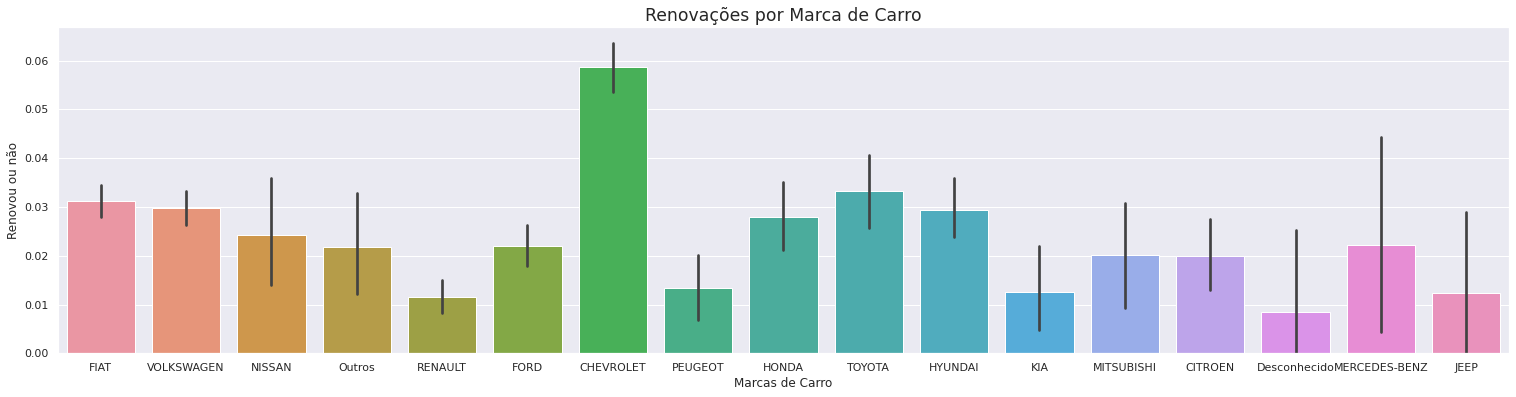

In [73]:
plt.figure(figsize=(26,6))
sns.barplot(x=df['CdMarca'], y=df['fl_renovou'])
plt.title("Renovações por Marca de Carro", fontsize='x-large', style='normal')
plt.xlabel('Marcas de Carro')
plt.ylabel('Renovou ou não')
plt.show()

In [17]:
df.groupby(['CdMarca', 'fl_renovou'],as_index=False).sum()

,CdMarca,fl_renovou,ID,Capacidade_de_Pagamento_7,tempo_desde_primeiro_contrato,tempo_desde_ultimo_contrato,QTD_OUTROS,QTD_CP_CONSIGNADO,QTD_CDCCG,QTD_CONTA_DIGITAL,...,VrContrato,QtParcelas,Grupo_Etario,Capacidade_de_Pagamento_1,Capacidade_de_Pagamento_2,Capacidade_de_Pagamento_3,Capacidade_de_Pagamento_4,Capacidade_de_Pagamento_5,Capacidade_de_Pagamento_6,NV_FC_CPC___Responsavel_6m
0,,0,2881654,799,154567.0,23281.0,1,2,52,38,...,16.213078,5517,530,55,-8.281553,-40.493102,-41.981796,22.118926,-16.008716,12
1,,1,39160,8,4142.0,178.0,0,0,1,1,...,-1.330679,48,4,0,-0.673343,0.369291,0.465179,0.361924,0.714909,0
2,CHEVROLET,0,189371867,56724,12571860.0,1570041.0,81,117,3497,2431,...,-603.208265,387947,35782,4517,-175.713818,639.919466,396.881895,-63.340314,-13.062288,830
3,CHEVROLET,1,12932418,3507,793400.0,94965.0,6,7,260,147,...,107.815747,23766,2371,251,-50.606263,67.191720,47.897106,45.572270,7.220439,29
4,CITROEN,0,34869974,9516,1634416.0,246623.0,23,11,668,584,...,30.205164,61655,5710,671,44.578073,9.109376,-96.598183,186.974060,-6.475139,210
5,CITROEN,1,778745,187,25827.0,4953.0,0,0,9,10,...,-3.707393,1205,138,9,-2.449024,3.374236,-3.647226,7.616897,-4.818387,1
6,FIAT,0,229983757,66773,10317460.0,1904397.0,147,107,3664,3713,...,-2838.526407,452176,40444,7896,192.075610,357.982607,93.509063,-690.328127,56.464177,1033
7,FIAT,1,8124039,2210,377823.0,57560.0,4,7,117,144,...,-81.953960,14400,1405,247,-58.813941,41.862115,32.352865,-2.880900,28.654688,20
8,FORD,0,115226729,32144,4840949.0,852692.0,60,50,1831,1986,...,332.400543,217547,21020,2807,-452.135863,320.146762,319.528071,-600.811015,-272.921278,540
9,FORD,1,2721111,726,140233.0,18448.0,0,1,41,42,...,26.171148,4828,472,67,-29.040726,12.821150,28.754663,13.313003,-6.647757,7


In [18]:
df=df.replace(to_replace =' ou +', value = ' ', regex = True)

## 6- Divisão da base de dados entre Treino-Teste

In [19]:
X=df.drop(['ID','fl_renovou'], axis=1)
y=df['fl_renovou']

In [21]:
encoder = LabelEncoder()
X['QTD_SEGURO'] = encoder.fit_transform(df['QTD_SEGURO'])
X['NmMotivoContratoFinanceiro'] = encoder.fit_transform(df['NmMotivoContratoFinanceiro'])
X['Sub_Produto'] = encoder.fit_transform(df['Sub_Produto'])
X['CdMarca'] = encoder.fit_transform(df['CdMarca'])
X['FlZeroKm'] = encoder.fit_transform(df['FlZeroKm'])
X['CdUfNaturalidade'] = encoder.fit_transform(df['CdUfNaturalidade'])
X['CdOcupacaoCBO'] = encoder.fit_transform(df['CdOcupacaoCBO'])

In [22]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

## 7-Seleção do Modelo de Aprendizado de Máquina- Classificador XGBoost

In [23]:
clf = XGBClassifier(eval_metric='mlogloss')

clf=clf.fit(X_train, y_train)

In [24]:
y_pred= clf.predict(X_test)

## 8- Avaliação das Métricas dos dados desbalanceados

In [25]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9670
           1       0.00      0.00      0.00       330

    accuracy                           0.97     10000
   macro avg       0.48      0.50      0.49     10000
weighted avg       0.94      0.97      0.95     10000



<AxesSubplot:>

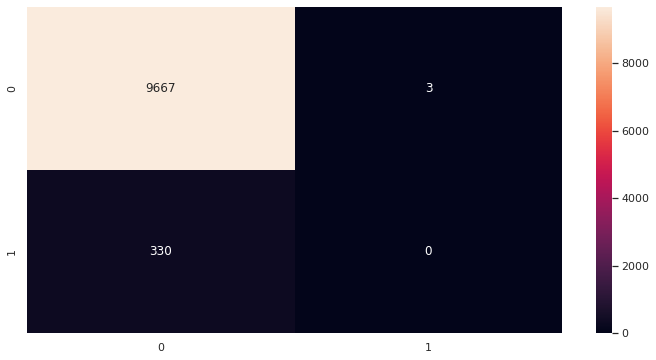

In [26]:
cf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt= 'g')

## 9- Rebalancear os dados para melhorar o desempenho

In [27]:
oversampler_random= RandomOverSampler()
X_random, y_random=oversampler_random.fit_resample(X, y)
X_random= pd.DataFrame(data=X_random, columns=X.columns)
X_train_random, X_test_random, y_train_random, y_test_random= train_test_split(X_random, y_random, test_size=0.2, random_state=42)

 ## 10-Comparação com duas dimensões de um PCA entre os dados balanceados e desbalanceados.

In [28]:
from sklearn.decomposition import PCA
#criar os pcas pros dados
pca=PCA(n_components=2)
pca_random=PCA(n_components=2)

#fitar o pca nos dados
pc=pca.fit_transform(X)
pc_random=pca_random.fit_transform(X_random)

# criar dataframes 
pc_df=pd.DataFrame(data=pc, columns=['pc1', 'pc2'])
pc_random_df=pd.DataFrame(data=pc_random, columns=['pc1', 'pc2'])
 
#avaliação do explained variance ratio
print(pca.explained_variance_ratio_)
print(pca_random.explained_variance_ratio_)

[0.99814711 0.00174107]
[0.99818507 0.0017067 ]


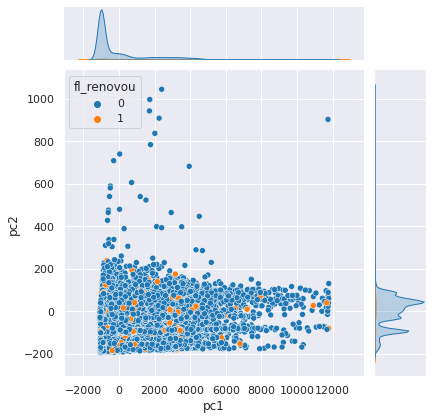

In [30]:
sns.jointplot(data=pc_df, x='pc1', y='pc2', hue=y, palette='tab10')

# 11- Treino do modelo sobre os dados rebalanceados

In [32]:
clf_random = XGBClassifier(eval_metric='mlogloss')

clf_random= clf_random.fit(X_train_random, y_train_random)

y_pred_random= clf_random.predict(X_test_random)

## 12-Avaliação das métricas dos dados balanceados

In [33]:
print(metrics.classification_report(y_test_random, y_pred_random))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      9747
           1       0.90      0.98      0.94      9617

    accuracy                           0.94     19364
   macro avg       0.94      0.94      0.94     19364
weighted avg       0.94      0.94      0.94     19364



In [ ]:
sns.jointplot(data=pc_random_df, x='pc1', y='pc2', hue=y_random, palette='tab10')
plt.title("Probabilidade de Renovação", fontsize='x-large', style='normal')
plt.show()

<AxesSubplot:>

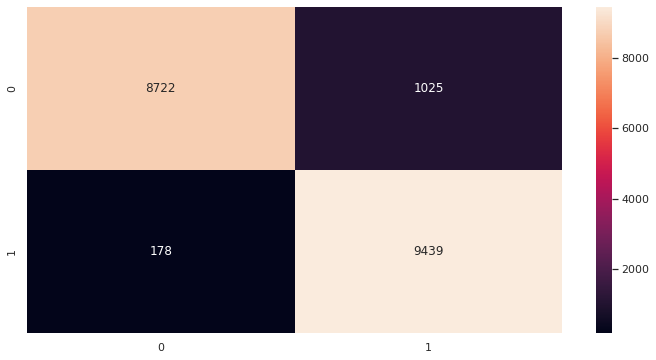

In [35]:
cf_matrix=confusion_matrix(y_test_random, y_pred_random)
sns.heatmap(cf_matrix, annot=True, fmt='g')

## 13- Verificação das features mais importantes e seus respectivos scores 

Feature: 0, Score: 0.02889
Feature: 1, Score: 0.03820
Feature: 2, Score: 0.03317
Feature: 3, Score: 0.03210
Feature: 4, Score: 0.02650
Feature: 5, Score: 0.01982
Feature: 6, Score: 0.02296
Feature: 7, Score: 0.03327
Feature: 8, Score: 0.07327
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.03332
Feature: 11, Score: 0.03838
Feature: 12, Score: 0.04044
Feature: 13, Score: 0.03977
Feature: 14, Score: 0.08133
Feature: 15, Score: 0.01441
Feature: 16, Score: 0.04383
Feature: 17, Score: 0.03724
Feature: 18, Score: 0.04141
Feature: 19, Score: 0.03549
Feature: 20, Score: 0.03360
Feature: 21, Score: 0.03403
Feature: 22, Score: 0.03380
Feature: 23, Score: 0.03509
Feature: 24, Score: 0.03133
Feature: 25, Score: 0.11833


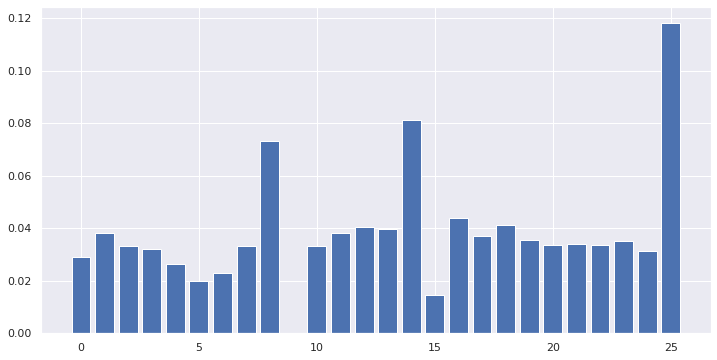

In [40]:
importance = clf_random.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

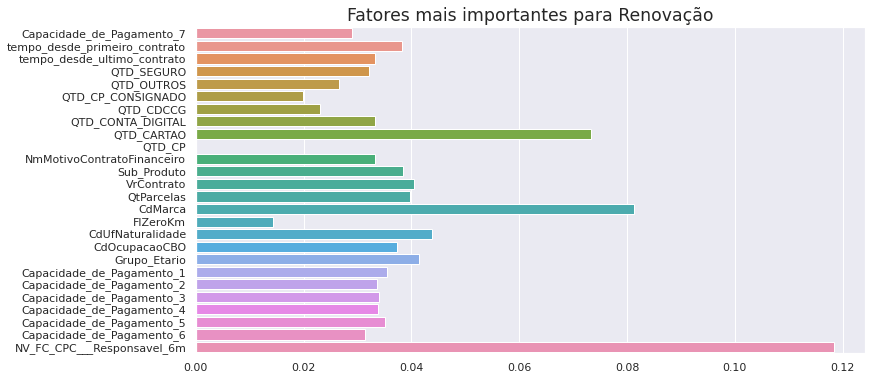

In [74]:
sns.barplot(y=X.columns, x=clf_random.feature_importances_)
plt.title("Fatores mais importantes para Renovação", fontsize='x-large', style='normal')
plt.show()

## 14- Colunas relevantes

QTD_CARTAO- Quantidade de cartões que o cliente tinha antes do envio do mailing

CdMarca- Marca do Veículo --> Chevrolet

NV_FC_CPC / Responsável_6m-Referente a contato com a pessoa certa/ Responsável nos últimos 6 meses

## 15-Em suma:

Após a analise de dados e o uso das aplicações de aprendizado de máquina, pudemos constatar que as váriaveis mais importantes para a renovação de contrato do seguro são as váriavéis acerca da: 
Quantidade de cartões que o cliente tinha antes do envio do mailing (indicando que clientes que já tem o vínculo com o Banco pelo uso de cartão de crédito tem uma propensão maior para estreitar essa relação contratando o seguro Auto),
a marca do Carro (Os clientes com carros da Chevrolet tem maior propensão a renovar o contrato) 
e contato com o cliente nos últimos 6 meses (indicando que o contato com o cliente pelas diversas plataformas que o banco atua influenciam muito na renovação do contrato)
